In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_absolute_error
from scipy.stats import ttest_ind
from scipy.stats import shapiro, anderson, kstest, norm
import scipy.stats as stats
import pickle

#data = pd.read_csv('data/wnba_train_over_under_data.csv')
#df= pd.read_csv('data/wnba_train_regression.csv')
df = pd.read_csv('data/2023_wnba_season.csv')
# df.drop(['Player ID', 'Date'], axis=1, inplace=True)
#OU = df['OU Result']
#df.drop(['OU Result'], axis=1, inplace=True)

#class_counts = OU.value_counts()
#print(class_counts)
points = df['Points']


# Load the model from the file
with open('models/linear_regression/linear_regression_model.pkl', 'rb') as file:
    loaded_model = pickle.load(file)

relative_performance = df['Relative Performance']

shifted_relative_performance = relative_performance + 35 + 1  # Shift to make all values positive
sqrt_relative_performance = np.sqrt(shifted_relative_performance)

# Now you can use the loaded model to make predictions
predictions = loaded_model.predict(np.array(sqrt_relative_performance).reshape(-1, 1))

# Print point
df['Adjusted Points'] = df['DARKO'] + predictions
df["DARKO L10"] = df["DARKO"] - df["L10 Median"]
df["Difference"] = df["Points"] - df["L10 Median"]
#df["Line Residual"] = df['Line'] - df["Points"]
df["DARKO Difference"] = df["Points"] - df["DARKO"]
print(df.describe())

print(df[df["Difference"] > 5])


          Player ID   L10 Median       Kalman        DARKO  \
count  1.708000e+03  1708.000000  1708.000000  1708.000000   
mean   1.141936e+06    13.199941    13.612946    13.549368   
std    6.780100e+05     4.951905     4.984599     4.687023   
min    1.009400e+05     1.000000     2.919881     3.718797   
25%    2.043230e+05     9.000000     9.679604     9.516746   
50%    1.628279e+06    13.000000    13.120418    13.156599   
75%    1.629497e+06    16.500000    16.935697    17.144341   
max    1.641649e+06    26.000000    30.658959    26.291462   

       Relative Performance         Home     Recent T       Spread  \
count           1708.000000  1708.000000  1708.000000  1708.000000   
mean               1.003729     0.502927     0.079678     0.515222   
std               10.598807     0.500138     0.982477    14.483706   
min              -33.423077     0.000000    -3.647596   -40.000000   
25%               -6.000000     0.000000    -0.491477   -10.000000   
50%                0.

In [3]:
# Correlation matrix
correlation_matrix = df.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.show()


ValueError: could not convert string to float: '2023-09-10'

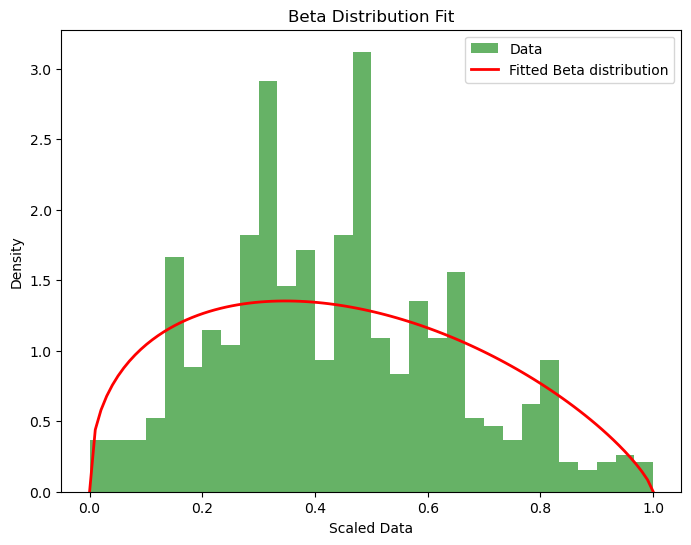

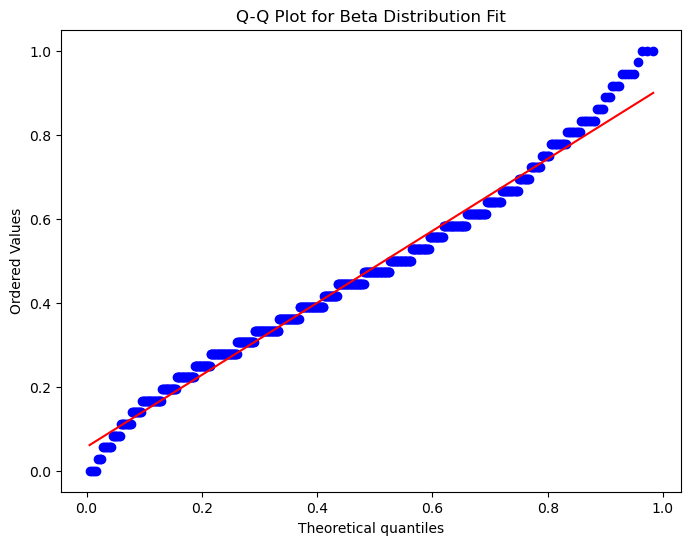

In [15]:
data = df['Points']

# Step 1: Ensure the data is in the range (0, 1)
min_data = np.min(data) - 1e-4
max_data = np.max(data) + 1e-4
data_scaled = (data - min_data) / (max_data - min_data)

# Step 2: Fit the Beta distribution
a, b, loc, scale = stats.beta.fit(data_scaled, floc=0, fscale=1)

# Step 3: Generate the Beta distribution with fitted parameters
x = np.linspace(0, 1, 100)
pdf_fitted = stats.beta.pdf(x, a, b, loc, scale)

# Step 4: Plot the data histogram and the fitted Beta distribution
plt.figure(figsize=(8, 6))
plt.hist(data_scaled, bins=30, density=True, alpha=0.6, color='g', label='Data')
plt.plot(x, pdf_fitted, 'r-', lw=2, label='Fitted Beta distribution')
plt.xlabel('Scaled Data')
plt.ylabel('Density')
plt.title('Beta Distribution Fit')
plt.legend()
plt.show()

plt.figure(figsize=(8, 6))
stats.probplot(data_scaled, dist="beta", sparams=(a, b, loc, scale), plot=plt)
plt.title('Q-Q Plot for Beta Distribution Fit')
plt.show()

Shapiro-Wilk Test p-value: 1.0
552 25
1.0345641544626347
0.3013074091374789
Kolmogorov-Smirnov Test: Statistic=0.044948533617519826, p-value=0.18837572236481093
Sample looks Gaussian (fail to reject H0)


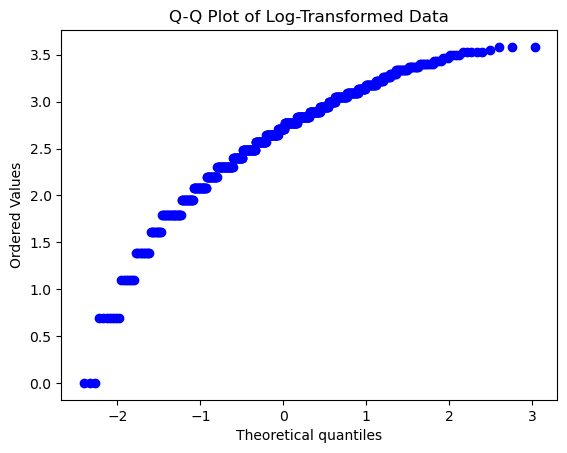

In [16]:

# Perform independent samples t-test

# Is the distribution log normal?
log_data = np.log(df['Points'])
shapiro_test = shapiro(log_data)
print(f'Shapiro-Wilk Test p-value: {shapiro_test.pvalue}')

# Is there a significant difference between players that seem to be doing well recently
cutoff = 1.5
points_home_0 = df[df["Recent T"] <= cutoff]["Difference"].values
points_home_1 = df[df["Recent T"] > cutoff]["Difference"].values
print(len(points_home_0), len(points_home_1))
t_stat, p_value = ttest_ind(np.array(points_home_0), np.array(points_home_1))
print(t_stat)
print(p_value)

# Home and Away?

# Kolmogorov-Smirnov Test
# slightly right skewed
data = np.array(df['Relative Performance'])
kstest_stat, kstest_p = kstest(data, 'norm', args=(np.mean(data), np.std(data)))
print(f'Kolmogorov-Smirnov Test: Statistic={kstest_stat}, p-value={kstest_p}')
if kstest_p > 0.05:
    print("Sample looks Gaussian (fail to reject H0)")
else:
    print("Sample does not look Gaussian (reject H0)")

# Residuals are NOT normally distributed -- suggests that a Kalman filter purely applied cannot be the best option
# Relative Performance is relatively gaussian

# Slight overprediction for home games


In [29]:
data = np.log(points)
params = stats.t.fit(data)

x = np.linspace(min(data), max(data), 1000)
pdf_fitted = stats.t.pdf(x, *params)

# Plot the histogram of the data and the fitted Lévy distribution
plt.figure(figsize=(10, 6))
plt.hist(data, bins=30, density=True, alpha=0.6, color='g', edgecolor='black', label='Data Histogram')
plt.plot(x, pdf_fitted, 'r-', lw=2, label='Fitted Lévy Distribution')
plt.title('Fit of Lévy Distribution to Data')
plt.xlabel('Data')
plt.ylabel('Density')
plt.legend()
plt.show()

ks_stat, p_value = stats.kstest(data, 't', args=params)

print(f'Kolmogorov-Smirnov test statistic: {ks_stat}')
print(f'p-value: {p_value}')

/Users/lzhao/miniconda3/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


ValueError: The data contains non-finite values.

In [5]:
# Estimate median absolute error for all estimators
print(f"Kalman Error: {mean_absolute_error(df['Points'], df['Kalman'])}")
print(f"L10 Median Error: {mean_absolute_error(df['Points'], df['L10 Median'])}")
#print(f"Line Error: {mean_absolute_error(df['Points'], df['Line'])}")
print(f"DARKO Error: {mean_absolute_error(df['Points'], df['DARKO'])}") 
print(f"Adjusted Points Error: {mean_absolute_error(df['Points'], df['Adjusted Points'])}") 

#5.46 with median, 0.98
# with median, 0.99
#5.476 with mean, 0.98
#5.41 with mean, 0.98
#5.486 with mean, 0.99

# L10 Median is a LESS BIASED estimator of the median of points than the line itself 
# best unbiased estimator is L10 Median, but it doesn't get the side 

Kalman Error: 5.251961010390295
L10 Median Error: 5.26844262295082
DARKO Error: 5.13022101244774
Adjusted Points Error: 4.9813145435545


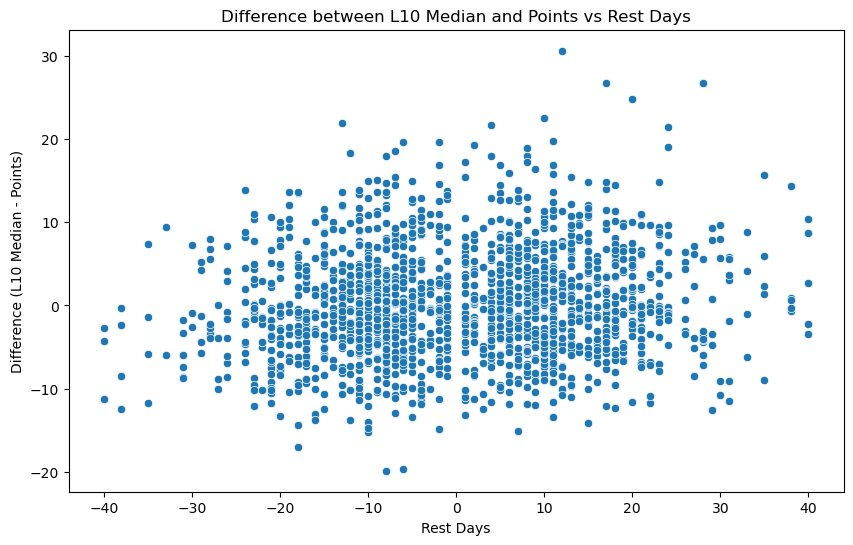

In [17]:

# Plot the difference against Rest Days
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='Spread', y='DARKO Difference')
plt.title('Difference between L10 Median and Points vs Rest Days')
plt.xlabel('Rest Days')
plt.ylabel('Difference (L10 Median - Points)')
plt.show()

# Relative performance vs team performance
# We should really be seeing a PARABOLIC trend -- player performance is maximized if it is a close game (i.e. points = -10 to 10) and minimized otherwise (points = 20 and above)

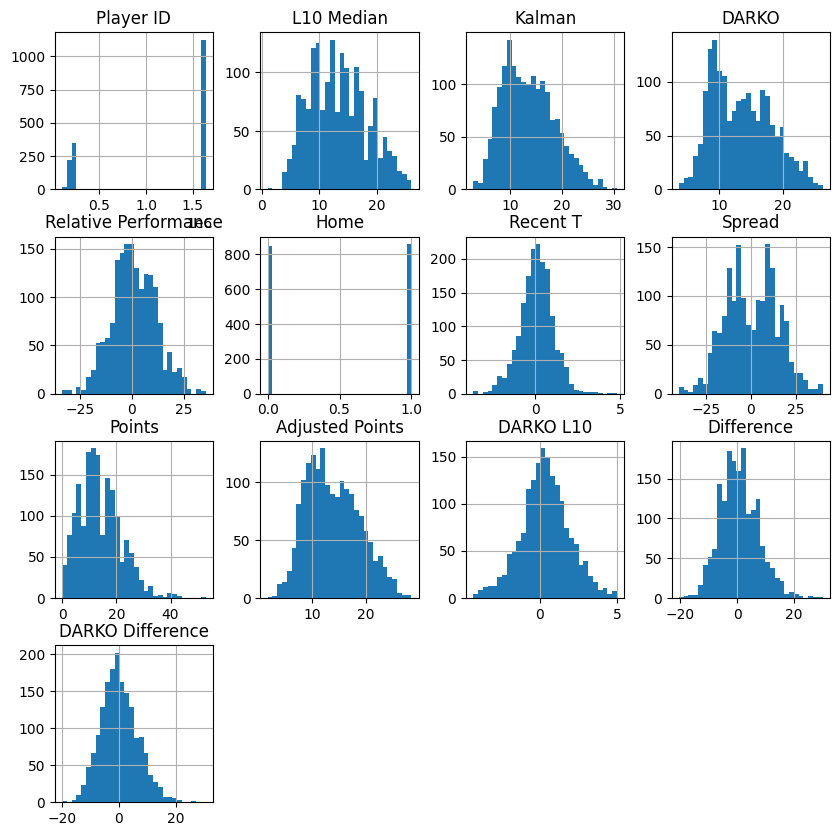

In [6]:
# Histograms
df.hist(bins=30, figsize=(10, 10))
plt.show()